In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=63b001070fce1eb2b74180ab0cd62e98cb5f6e913cf31b3be86ad4af4e2106af
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import InputExample
from datetime import datetime
import sys
import os
import gzip
import csv
import pandas as pd
from zipfile import ZipFile

In [ ]:
#Check if dataset exsist. If not, download and extract  it
dataset_path = 'quora-dataset/'

if not os.path.exists(dataset_path):
  zip_save_path = 'quora-IR-dataset.zip'
  util.http_get(url='https://sbert.net/datasets/quora-IR-dataset.zip',
                path = zip_save_path)
  with ZipFile(zip_save_path,'r') as zip:
    zip.extractall(dataset_path)

  0%|          | 0.00/93.6M [00:00<?, ?B/s]

In [ ]:
col_names = ['qid1','qid2','question1','question2','is_duplicate']
df_train = pd.read_csv(r'./quora-dataset/classification/train_pairs.tsv',
                       sep = '\t',
                       encoding='utf8',
                       on_bad_lines='skip')
df_train.head()


,qid1,qid2,question1,question2,is_duplicate
0,161796,124097,When is surge pricing on Uber generally in eff...,When is surge pricing on Uber generally in eff...,0.0
1,123279,123280,Why in India do we not have one on one politic...,Why cant we have a public debate between polit...,1.0
2,63742,63743,What is the scope of making career in Import E...,"I'm a cartoonist, how can I start sharing my w...",0.0
3,13778,13779,What do you think will be the effect of Modi G...,What are the full implications of the Indian g...,1.0
4,266204,266205,What is OnePlus One?,How is oneplus one?,1.0


In [ ]:
len(df_train)

277277

In [ ]:
df_train.isnull().sum()

qid1            0
qid2            0
question1       1
question2       0
is_duplicate    6
dtype: int64

In [ ]:
# drop null values
df_train.dropna(inplace=True)
df_train.reset_index(drop=True,inplace=True)
len(df_train)

277270

In [ ]:
train_samples = []
for i in range(len(df_train[:50000])):
  train_samples.append(InputExample(texts=[df_train.loc[i,'question1'],df_train.loc[i,'question2']],
                                    label = int(df_train.loc[i,'is_duplicate'])))

In [ ]:
df_dev = pd.read_csv(r'./quora-dataset/classification/dev_pairs.tsv',
                       sep = '\t',
                       encoding='utf8',
                       on_bad_lines='skip')
df_dev.head()

,qid1,qid2,question1,question2,is_duplicate
0,188855,188856,How did Michel Foucault feel about surveillanc...,What is Michel Foucaults opinion on surveillan...,1
1,231741,231742,What's the difference between a consumer and a...,What is the difference between a customer and ...,0
2,188420,188421,If 3x + 9y = 7x + y. then 8y=?,"In India, why does most of society overpromise...",0
3,736,147700,Do Mexican girls like black guys?,Do black girls like Mexican guys?,0
4,87103,247800,What does Pattern do?,What are the patterns in life?,0


In [ ]:
len(df_dev)

36971

In [ ]:
dev_samples = []
for i in range(len(df_dev)):
  dev_samples.append(InputExample(texts=[df_dev.loc[i,'question1'],df_dev.loc[i,'question2']],
                                    label = int(df_dev.loc[i,'is_duplicate'])))

In [ ]:
#Configuration
train_batch_size = 16
num_epochs = 4
model_save_path = 'output/training_quora-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#We use distilroberta-base with a single label, i.e., it will output a value between 0 and 1 indicating the similarity of the two questions
model = CrossEncoder('distilroberta-base', num_labels=1)

# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

# We add an evaluator, which evaluates the performance during training
evaluator = CEBinaryClassificationEvaluator.from_input_examples(dev_samples, 
                                                                name='Quora-dev')

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=5000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
df_test = pd.read_csv(r'./quora-dataset/classification/test_pairs.tsv',
                       sep = '\t',
                       encoding='utf8',
                       on_bad_lines='skip')
df_test.head()

,qid1,qid2,question1,question2,is_duplicate
0,219237,2646,"What is the ""Best pick-up line"" you ever heard...",What are the best pick up lines?,0
1,401324,447225,What is screening?,Was Shakespeare bisexual?,0
2,489618,324606,"If someone refuses to pay their debts, despite...",How does one graduate from a UC without much d...,0
3,3335,3336,"Marx said ""The religion is opium of the people...",Why are the Indian Left called anti-Hindu when...,0
4,100509,253822,What is the use of an HDMI port in an LED TV?,I tried connecting my Toshiba tv to a laptop w...,0


In [ ]:
test_samples = []
for i in range(len(df_test)):
  test_samples.append(InputExample(texts=[df_test.loc[i,'question1'],df_test.loc[i,'question2']],
                                    label = int(df_test.loc[i,'is_duplicate'])))

In [ ]:
len(test_samples)

80825

In [ ]:
##### Load model and eval on test set
model = CrossEncoder(model_save_path)

evaluator = CEBinaryClassificationEvaluator.from_input_examples(test_samples,name='Quora-test')
evaluator(model)

0.8655734156412537

In [ ]:
scores_epochs = pd.read_csv(r'/content/output/training_quora-2023-06-02_17-05-16/CEBinaryClassificationEvaluator_Quora-dev_results.csv')
scores_epochs

,epoch,steps,Accuracy,Accuracy_Threshold,F1,F1_Threshold,Precision,Recall,Average_Precision
0,0,-1,0.839036,0.438713,0.779242,0.272168,0.725332,0.841809,0.830983
1,1,-1,0.847529,0.404044,0.791634,0.200030,0.732149,0.861641,0.846780
2,2,-1,0.850883,0.385115,0.795127,0.137374,0.740255,0.858785,0.845965
3,3,-1,0.851127,0.376087,0.795838,0.038546,0.739372,0.861641,0.837476


In [ ]:
test = []
for i in range(len(df_test)):
  test.append([df_test.loc[i,'question1'],df_test.loc[i,'question2']])

predictions = model.predict(test,show_progress_bar=True)
predictions

Batches:   0%|          | 0/2526 [00:00<?, ?it/s]

array([0.58836895, 0.00134048, 0.0010398 , ..., 0.96092886, 0.95258844,
       0.33263075], dtype=float32)

In [ ]:
cos_sim = list(predictions)
df_test['cosine_sim'] = cos_sim
df_test.head()

,qid1,qid2,question1,question2,is_duplicate,cosine_sim
0,219237,2646,"What is the ""Best pick-up line"" you ever heard...",What are the best pick up lines?,0,0.588369
1,401324,447225,What is screening?,Was Shakespeare bisexual?,0,0.001340
2,489618,324606,"If someone refuses to pay their debts, despite...",How does one graduate from a UC without much d...,0,0.001040
3,3335,3336,"Marx said ""The religion is opium of the people...",Why are the Indian Left called anti-Hindu when...,0,0.004381
4,100509,253822,What is the use of an HDMI port in an LED TV?,I tried connecting my Toshiba tv to a laptop w...,0,0.001226


In [ ]:
# filter dataframes with duplicate == Yes
df_dup_1 = df_test[df_test['is_duplicate']==1]
df_dup_1.head()

,qid1,qid2,question1,question2,is_duplicate,cosine_sim
8,170284,170285,Why does America have nuclear weapons? Isn't i...,Why is America allowed to have and use nuclear...,1,0.784642
13,279652,279653,What would you do if you were in a female body...,Men of Quora: What would you do if you were in...,1,0.625375
16,59662,692,What are the good options for mobile phones un...,Which are best mobile phones to buy under 15000?,1,0.969833
17,375725,63443,Can you watch normal movies on VR glasses?,Can we see normal videos using vr glass?,1,0.776376
18,4415,57,What should I do to make money online in India?,What is best way to make money online?,1,0.023118


In [ ]:
# filter dataframe with duplicate == No
df_dup_0 = df_test[df_test['is_duplicate']==0]
df_dup_0.head()

,qid1,qid2,question1,question2,is_duplicate,cosine_sim
0,219237,2646,"What is the ""Best pick-up line"" you ever heard...",What are the best pick up lines?,0,0.588369
1,401324,447225,What is screening?,Was Shakespeare bisexual?,0,0.001340
2,489618,324606,"If someone refuses to pay their debts, despite...",How does one graduate from a UC without much d...,0,0.001040
3,3335,3336,"Marx said ""The religion is opium of the people...",Why are the Indian Left called anti-Hindu when...,0,0.004381
4,100509,253822,What is the use of an HDMI port in an LED TV?,I tried connecting my Toshiba tv to a laptop w...,0,0.001226


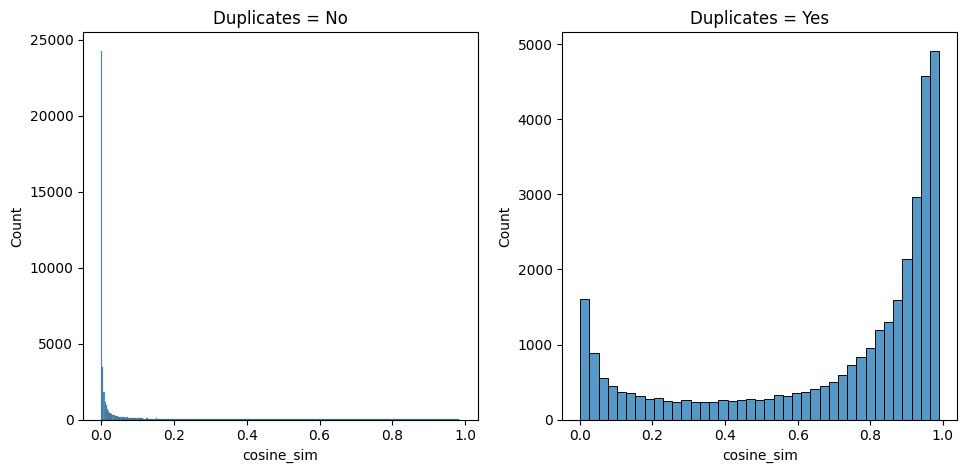

In [ ]:
# Histogram
import matplotlib.pyplot as plt
import seaborn as sns

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
fig.tight_layout(pad=3)
sns.histplot(df_dup_0['cosine_sim'],kde=False,ax=ax1)
sns.histplot(df_dup_1['cosine_sim'],kde=False,ax=ax2)
ax1.set_title('Duplicates = No')
ax2.set_title('Duplicates = Yes')
plt.show()

In [ ]:
df_pred = df_test[['cosine_sim','is_duplicate']]
df_pred.head()

,cosine_sim,is_duplicate
0,0.588369,0
1,0.001340,0
2,0.001040,0
3,0.004381,0
4,0.001226,0


In [ ]:
X = df_pred[['cosine_sim']]
y = df_pred['is_duplicate']

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(n_estimators=300)
model_rfc = rfc.fit(X,y)
y_pred = model_rfc.predict(X)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
print('Accuracy Score:',accuracy_score(y,y_pred))

Accuracy Score: 0.9946180018558615


In [ ]:
print('Classification Score:',classification_report(y,y_pred))

Classification Score:               precision    recall  f1-score   support

           0       0.99      1.00      1.00     48184
           1       1.00      0.99      0.99     32641

    accuracy                           0.99     80825
   macro avg       0.99      0.99      0.99     80825
weighted avg       0.99      0.99      0.99     80825



In [ ]:
# Read the quora dataset split for classification

train_samples = []
with open(os.path.join(dataset_path,'classification','train_pairs.tsv'),'r',encoding='utf8') as f:
  reader = csv.DictReader(f,delimiter='\t',quoting=csv.QUOTE_NONE)
  for row in reader:
    train_samples.append(InputExample(texts=[row['question1'],row['question2']],
                                      label = int(row['is_duplicate'])))
    train_samples.append(InputExample(texts=[row['question2'],row['question1']],
                                      label = int(row['is_duplicate'])))
    
dev_samples = []
with open(os.path.join(dataset_path,'classification','dev_pairs.tsv'),'r',encoding='utf8') as f:
  reader = csv.DictReader(f,delimiter='\t',quoting=csv.QUOTE_NONE)
  for row in reader:
    dev_samples.append(InputExample(texts=[row['question1'],row['question2']],
                                      label = int(row['is_duplicate'])))
    
#Configuration
train_batch_size = 16
num_epochs = 4
model_save_path = 'output/training_quora-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#We use distilroberta-base with a single label, i.e., it will output a value between 0 and 1 indicating the similarity of the two questions
model = CrossEncoder('distilroberta-base', num_labels=1)

# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

# We add an evaluator, which evaluates the performance during training
evaluator = CEBinaryClassificationEvaluator.from_input_examples(dev_samples, 
                                                                name='Quora-dev')

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=5000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)



Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/34790 [00:00<?, ?it/s]

Iteration:   0%|          | 0/34790 [00:00<?, ?it/s]

Iteration:   0%|          | 0/34790 [00:00<?, ?it/s]

Iteration:   0%|          | 0/34790 [00:00<?, ?it/s]

In [ ]:
test_samples = []
with open(os.path.join(dataset_path,'classification','test_pairs.tsv'),'r',encoding='utf8') as f:
  reader = csv.DictReader(f,delimiter='\t',quoting=csv.QUOTE_NONE)
  for row in reader:
    test_samples.append(InputExample(texts=[row['question1'],row['question2']],
                                      label = int(row['is_duplicate'])))
    
##### Load model and eval on test set
model = CrossEncoder(model_save_path)

evaluator = CEBinaryClassificationEvaluator.from_input_examples(test_samples,name='Quora-test')
evaluator(model)